In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import h5py
import ipywidgets as widgets
import utils_hb as hb

from scipy.optimize import curve_fit
from scipy.constants import Planck, hbar, Boltzmann

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.frameon'] = False

# Greek alphabet: α, β, γ, δ, ε, ζ, η, θ, ι, κ, λ, μ, ν, ξ, ο, π, ρ, ς, σ, τ, υ, φ, χ, ψ, ω

π = np.pi

In [3]:
def load_data(file, meas_type_, run_):
    idx_str = "{}/{}".format(meas_type_, run_)

    # Open hdf5 file
    with h5py.File(file, 'r') as dataset:

        # Attributes
        df = dataset[idx_str].attrs['df']
        fNCO = dataset[idx_str].attrs['fNCO']

        # Data
        freq_det_arr = np.asarray(dataset[idx_str]['comb detuning'])
        freq_center_arr = np.asarray(dataset[idx_str]['center freq'])
        drive_amp_arr = np.asarray(dataset[idx_str]['drive amp sweep'])
        usb_arr = np.asarray(dataset[idx_str]["USB"])
        
    return usb_arr, drive_amp_arr, freq_center_arr, freq_det_arr, df, fNCO


def dB(data):
    return 20 * np.log10(np.abs(data))


def FS_out2dBm(FSout):
    return 20 * np.log10(FSout) - 18.1689743088677


def FS_in2dBm(FSin):
    return 20 * np.log10(FSin) + 9.67986146473929


def dBm2W(dBm):
    return 10**((dBm - 30) / 10)


def dBm2V(dBm):
    return np.sqrt(10**((dBm - 30) / 10) * 50)


def W2n(W, Ql_, Qc_, fr_):
    return 2 / np.pi * Ql_**2 / Qc_ * W / (hbar * (2 * np.pi * fr_)**2)


def FS_out2W(FSout):
    return 10**((-18.1689743088677 - 30) / 10) * FSout**2


def FS_in2W(FSin):
    return 10**((9.67986146473929 - 30) / 10) * FSin**2


def FS_out2V(FSout):
    return np.sqrt(50) * 10**((-18.1689743088677 - 30) / 20) * FSout


def FS_in2V(FSin):
    return np.sqrt(50) * 10**((9.67986146473929 - 30) / 20) * FSin


def V2n(V, Ql_, Qc_, fr_):
    return 2 / np.pi * Ql_**2 / Qc_ * V**2 / 50 / (hbar * (2 * np.pi * fr_)**2)

def n2V(n, Ql_, Qc_, fr_):
    return np.sqrt(n / (2 / np.pi * Ql_**2 / Qc_ / 50 / (hbar * (2 * np.pi * fr_)**2)))

(270, 15, 33)


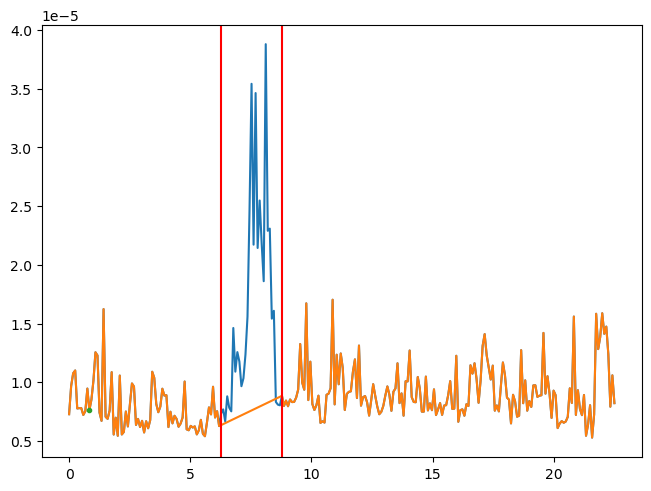

(15, 33)


In [4]:
# Load raw data
verbose = False

# Load on resonance data
file = r'/media/jc/2022-11/TLS-Data/Chalmers-Data/OneDrive_2023-11-14/IMP over time/timesweep.hdf5'
meas_type = 'Frequency sweep'
run = '2023-01-01_14_48_45'
usb_arr, amp_drives, freq_center, freq_comb, df, fNCO = load_data(file, meas_type, run)
print(np.shape(usb_arr))

avg = 1000
end = len(amp_drives) * len(freq_center) * avg / df / 3600  # measurement length in hours
time = np.linspace(0, end, len(amp_drives))

index = np.arange(75, 105, 1)
usb_arr_filtered = np.delete(usb_arr, index, axis=0)
time_filtered = np.delete(time, index, axis=0)
index_test = 10

fig, ax = plt.subplots(1)
ax.plot(time, np.abs(usb_arr[:, len(freq_center) // 2, 19]))
ax.plot(time_filtered, np.abs(usb_arr_filtered[:, len(freq_center) // 2, 19]))
ax.plot(time[index_test], np.abs(usb_arr[index_test, len(freq_center) // 2, 19]), '.')
ax.axvline(time[75], c='r')
ax.axvline(time[105], c='r')
plt.show()

print(np.shape(np.mean(usb_arr_filtered, axis=0)))

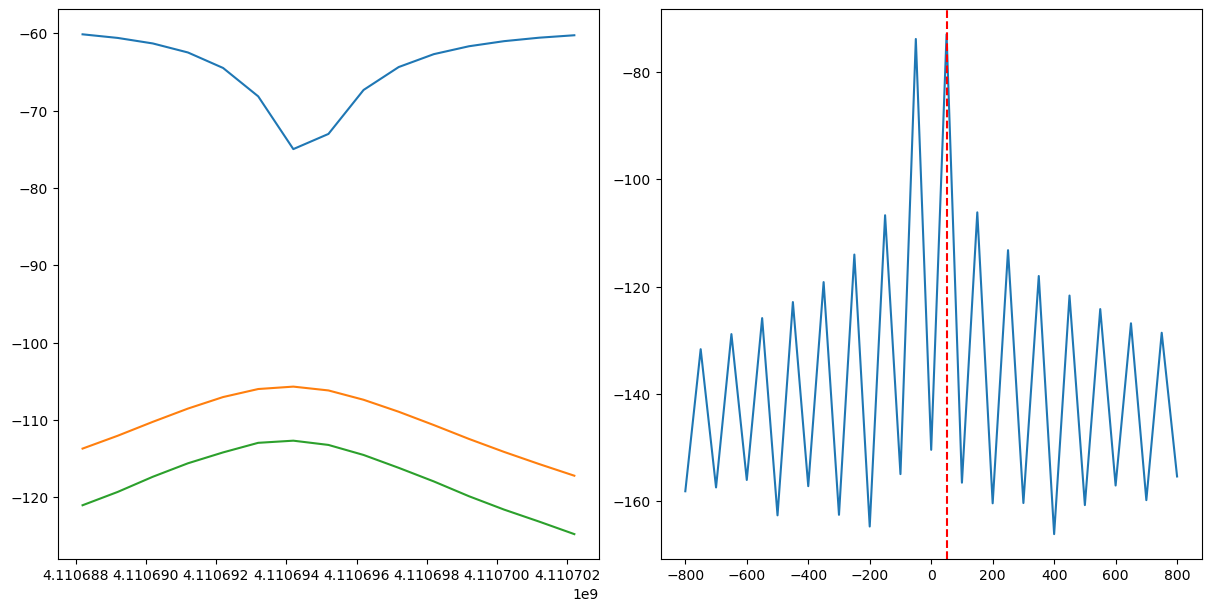

In [5]:
usb_arr = np.mean(usb_arr_filtered, axis=0)
# usb_arr = np.mean(usb_arr_filtered[0:100], axis=0)
# usb_arr = np.mean(usb_arr_filtered[90:100], axis=0)
# usb_arr = usb_arr_filtered[1]
# usb_arr = usb_arr[97]


# data in POWER: dBm, W and photon number
usb_arr_dbm = FS_in2dBm(np.abs(usb_arr))
usb_arr_w = dBm2W(usb_arr_dbm)

# data in AMPLITUDE: V
usb_arr_v = FS_in2V(usb_arr)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(freq_center, dB(usb_arr_v[:, 17]))
ax[0].plot(freq_center, dB(usb_arr_v[:, 19]))
ax[0].plot(freq_center, dB(usb_arr_v[:, 21]))

ax[1].plot(freq_comb, dB(usb_arr_v[7, :]))
ax[1].axvline(freq_comb[17], ls='--', c='red')

plt.show()

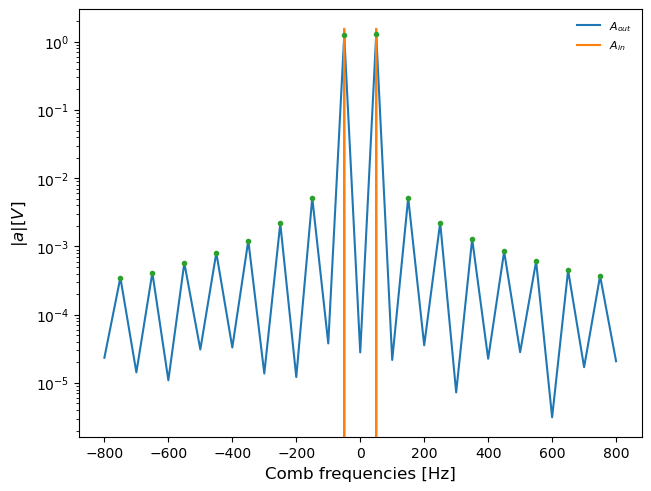

In [6]:
# Reconstruction
freq_idx = 10

scaling_factor = 1e7

G = 75.08661509030415
att = 65

G_lin = 10**(G / 10)
att_lin = 10**(att / 10)

amp_drives_v = FS_out2V(amp_drives[0])


# Output field in frequency and time domain in Volts
Aout = scaling_factor * usb_arr_v[freq_idx] / np.sqrt(G_lin)
aout = np.fft.ifft(Aout)
aout *= len(aout)

# Input field in frequency and time domain
ind_drive = np.array([15, 17])

Ain = np.zeros_like(Aout, dtype=complex)
Ain[ind_drive[0]] = scaling_factor * np.exp(1.0j*0.30708073906847805) * amp_drives_v / np.sqrt(att_lin)
Ain[ind_drive[1]] = scaling_factor * np.exp(1.0j*-1.102388038623899) * amp_drives_v / np.sqrt(att_lin)
ain = np.fft.ifft(Ain)
ain *= len(ain)


# Intermodulation product indices
nimps = 14
ind_imp = np.arange(ind_drive[0]-nimps, ind_drive[1]+nimps+2, 2)


# Plot spectra
fig, ax = plt.subplots(1)

ax.semilogy(freq_comb, np.abs(Aout), label='$A_{out}$')
ax.semilogy(freq_comb, np.abs(Ain), label='$A_{in}$')
ax.semilogy(freq_comb[ind_imp], np.abs(Aout)[ind_imp], '.')

ax.set_xlabel('Comb frequencies [Hz]')
ax.set_ylabel('$|a| [V]$')
ax.legend()

plt.show()

# fig.savefig(r'/home/jc/OneDrive/PhD/Talks/TLS/Fig-Exp-Spectra-10avg.png')

In [7]:
# Circle fit's values
f0_j = 4.11e9
ktot_j = 7.63e3
kint_j = 0.86e3
kext_j = 6.77e3
ktls_j = 3.95e3
beta_j = 0.3
ac_n_j = np.sqrt(2)
ac_j = n2V(np.sqrt(2), 2*np.pi*f0_j/kext_j, 2*np.pi*f0_j/ktot_j, f0_j)*scaling_factor
print(ac_j/scaling_factor)

1.3479623589763515e-09


In [8]:
# Reconstruction order
order_val = 9
n = np.arange(0, order_val, 2)

kext_rec, fr_rec, c_rec, Q_fit = hb.tls_reconstruction(Field=Aout,
                                                       Field_in=Ain,
                                                       field=aout,
                                                       field_in=ain,
                                                       freqs=freq_comb,
                                                       indices=ind_imp,
                                                       order=n,
                                                       in_out=True,
                                                       daniel=False,
                                                       )


# Print results
print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15}'.format('Parameter','Poly Rec') + '\033[0m')
print('{:<15} {:<15}'.format('kext', f'{kext_rec:.5e}'))
print('{:<15} {:<15}'.format('f0', f'{fr_rec+freq_center[freq_idx]:.5e} Hz'))
print('{:<15} {:<15}'.format('c1', f'{c_rec[0]:.5e}'))
for order_ind, order_val in enumerate(n[:-1]):
    print('{:<15} {:<15}'.format(f'c{order_val+3}', f'{c_rec[order_ind+1]:.5e}'))

RECONSTRUCTED PARAMETERS
Parameter       Poly Rec       
kext            6.47752e+03    
f0              4.11070e+09 Hz 
c1              6.33983e+03    
c3              -6.92160e+02   
c5              4.14952e+02    
c7              -1.11439e+02   
c9              1.07968e+01    


In [9]:
# TLS damping function (FIX k0 to Janka)
def tls_function(x, κ0_, κtls_, ac_, beta_, kext_):
    return κ0_ / 2 + κtls_ / 2 / (1 + (np.abs(x) / (np.sqrt(kext_) * ac_))**2)**beta_

# We simulate the TLS non-linearity
xmax = np.max(np.abs(Aout - Ain))
x_sim = np.linspace(0, xmax, 10000)
# Reconstructed damping using complex time-domain spectra
y_rec = 0
for coef_ind, coef_val in enumerate(c_rec):
    y_rec += coef_val * x_sim**(2 * coef_ind)

# curve fit of the reconstructed damping to get the tls parameters
popt = curve_fit(lambda x_sim, κ0_, κtls_, ac_, beta_: tls_function(x_sim, 0.86e3+kext_rec, κtls_, ac_, 0.3, kext_rec), 
                 x_sim,
                 y_rec,
                 p0=[0.86e3+kext_rec, 8.19938e+02, 1e-2, 0.3],
                 # p0=[7e+03, 15e3, 1, 0.3],
                 maxfev=10_000,
                )

param_rec_hb = np.append(fr_rec+freq_center[freq_idx], [*popt[0], kext_rec])

# Qfactors
Qc = param_rec_hb[0] / param_rec_hb[5]
Ql =  param_rec_hb[0] / param_rec_hb[1]
Qi = param_rec_hb[0] / (param_rec_hb[1] - param_rec_hb[5])

ac_n = V2n(param_rec_hb[3]/scaling_factor, 2*np.pi*Qc, 2*np.pi*Ql, param_rec_hb[0])

print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15} {:<15}'.format('Parameter', 'Circle Fit', 'TLS Rec') + '\033[0m')
print('{:<15} {:<15} {:<15}'.format('f0', f'{f0_j:.2e} Hz', f'{param_rec_hb[0]:.2e} Hz'))
print('{:<15} {:<15} {:<15}'.format('κint', f'{kint_j:.2e} Hz', f'{param_rec_hb[1]-param_rec_hb[-1]:.2e} Hz'))
print('{:<15} {:<15} {:<15}'.format('Qint', f'{f0_j/kint_j:.2e}', f'{Qi:.2e}'))
print('{:<15} {:<15} {:<15}'.format('kext', f'{kext_j:.2e} Hz', f'{param_rec_hb[-1]:.2e} Hz'))
print('{:<15} {:<15} {:<15}'.format('Qext', f'{f0_j/kext_j:.2e}', f'{Qc:.2e}'))
print('{:<15} {:<15} {:<15}'.format('κtot', f'{ktot_j:.2e} Hz', f'{param_rec_hb[1]:.2e} Hz'))
print('{:<15} {:<15} {:<15}'.format('Qtot', f'{f0_j/ktot_j:.2e}', f'{Ql:.2e}'))
print('{:<15} {:<15} {:<15}'.format('κtls', f'{ktls_j:.2e} Hz', f'{param_rec_hb[2]:.2e} Hz'))
print('{:<15} {:<15} {:<15}'.format('ac', f'{ac_n_j:.3e}', f'{ac_n:.3e}'))
print('{:<15} {:<15} {:<15}'.format('β', f'{beta_j:.2e}', f'{param_rec_hb[4]:.2e}'))

RECONSTRUCTED PARAMETERS
Parameter       Circle Fit      TLS Rec        
f0              4.11e+09 Hz     4.11e+09 Hz    
κint            8.60e+02 Hz     8.60e+02 Hz    
Qint            4.78e+06        4.78e+06       
kext            6.77e+03 Hz     6.48e+03 Hz    
Qext            6.07e+05        6.35e+05       
κtot            7.63e+03 Hz     7.34e+03 Hz    
Qtot            5.39e+05        5.60e+05       
κtls            3.95e+03 Hz     5.32e+03 Hz    
ac              1.414e+00       1.768e+00      
β               3.00e-01        3.00e-01       


/home/jc/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


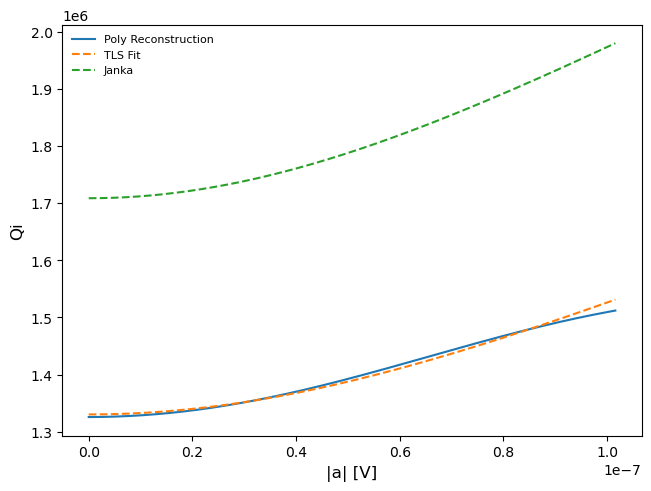

In [10]:
# Plotting
fig, ax = plt.subplots(1)

ax.plot(x_sim/1e7, param_rec_hb[0] / (y_rec - kext_rec/2), label='Poly Reconstruction')
ax.plot(x_sim/1e7, param_rec_hb[0] / (tls_function(x_sim, param_rec_hb[1], param_rec_hb[2], param_rec_hb[3], param_rec_hb[4], param_rec_hb[5]) - param_rec_hb[5]/2), '--', label='TLS Fit')
ax.plot(x_sim/1e7, f0_j / (tls_function(x_sim, ktot_j, ktls_j, ac_j, beta_j, kext_j) - kext_j/2), '--', label='Janka')
# ax.plot(x_sim/1e7, param_rec_hb[0] / (tls_function(x_sim, ktot_j, param_rec_hb[2], param_rec_hb[3], param_rec_hb[4], param_rec_hb[5]) - param_rec_hb[5]/2), '--', label='TLS Fit kext correction')
# ax.plot(x_sim/1e7, param_rec_hb[0] / (tls_function(x_sim, param_rec_hb[1], param_rec_hb[2], param_rec_hb[3], 0.15, param_rec_hb[5]) - param_rec_hb[5]/2), '--', label='TLS Fit')

ax.set_xlabel('|a| [V]')
ax.set_ylabel('Qi')
ax.legend()

plt.show()

# fig.savefig(r'/home/jc/OneDrive/PhD/Talks/TLS/Fig-Exp-Qi_rec-240avg.png')